<a href="https://colab.research.google.com/github/B21-CAP0075/Dementia-Classification/blob/development/cdr_binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir /root/.kaggle/
! cp "/content/drive/My Drive/Machine Learning/kaggle.json" /root/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

     |████████████████████████████████| 61kB 8.5MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=60be80cf7d9efcdb4dae80df4f23526bb7b6d35d29b73e5d60622579a47fd843
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
! kaggle datasets download -d jboysen/mri-and-alzheimers

  0% 0.00/12.6k [00:00<?, ?B/s]
100% 12.6k/12.6k [00:00<00:00, 10.8MB/s]


In [5]:
zip_ref = zipfile.ZipFile('mri-and-alzheimers.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
df_cross = pd.read_csv('oasis_cross-sectional.csv')
df_cross.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [7]:
df_long = pd.read_csv('oasis_longitudinal.csv')
df_long.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [8]:
df_cross = df_cross.drop(columns=['ID', 'Delay', 'Hand', 'eTIV', 'nWBV', 'ASF'])
df_cross.columns = ['M/F', 'Age',	'EDUC',	'SES',	'MMSE',	'CDR']
df_cross.head()

,M/F,Age,EDUC,SES,MMSE,CDR
0,F,74,2.0,3.0,29.0,0.0
1,F,55,4.0,1.0,29.0,0.0
2,F,73,4.0,3.0,27.0,0.5
3,M,28,NaN,NaN,NaN,NaN
4,M,18,NaN,NaN,NaN,NaN


In [9]:
df_long = df_long.drop(columns=['Subject ID', 'MRI ID', 'Visit', 'MR Delay', 'Hand', 'eTIV', 'nWBV', 'ASF', 'Group'])
df_long.head()

,M/F,Age,EDUC,SES,MMSE,CDR
0,M,87,14,2.0,27.0,0.0
1,M,88,14,2.0,30.0,0.0
2,M,75,12,NaN,23.0,0.5
3,M,76,12,NaN,28.0,0.5
4,M,80,12,NaN,22.0,0.5


In [10]:
df = pd.concat([df_cross, df_long])
df = df[df['CDR'].notna()]
df = df[df['SES'].notna()]
df = df[df['MMSE'].notna()]
df

,M/F,Age,EDUC,SES,MMSE,CDR
0,F,74,2.0,3.0,29.0,0.0
1,F,55,4.0,1.0,29.0,0.0
2,F,73,4.0,3.0,27.0,0.5
8,M,74,5.0,2.0,30.0,0.0
9,F,52,3.0,2.0,30.0,0.0
...,...,...,...,...,...,...
368,M,82,16.0,1.0,28.0,0.5
369,M,86,16.0,1.0,26.0,0.5
370,F,61,13.0,2.0,30.0,0.0
371,F,63,13.0,2.0,30.0,0.0


In [11]:
df['CDR'] = df['CDR'].replace(
    [0.0, 0.5, 1.0, 2.0],
    [0, 0, 1, 1]
)

print(df['CDR'].unique())

[0. 1.]


In [12]:
df_temp = df[df['CDR'] == 0]
df_temp = df_temp[:200]
new_df = df_temp.append(df[df['CDR'] == 1])

df = new_df
print(len(df))

264


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


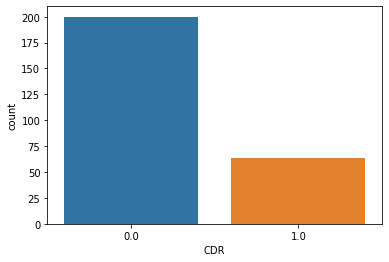

In [13]:
sns.countplot(df['CDR'])

In [14]:
df.isnull().sum()

M/F     0
Age     0
EDUC    0
SES     0
MMSE    0
CDR     0
dtype: int64

In [15]:
gender = pd.get_dummies(df['M/F'])

df = df.drop(columns=['M/F'])
df = pd.concat([df, gender], axis=1)
df

,Age,EDUC,SES,MMSE,CDR,F,M
0,74,2.0,3.0,29.0,0.0,1,0
1,55,4.0,1.0,29.0,0.0,1,0
2,73,4.0,3.0,27.0,0.0,1,0
8,74,5.0,2.0,30.0,0.0,0,1
9,52,3.0,2.0,30.0,0.0,1,0
...,...,...,...,...,...,...,...
329,77,20.0,1.0,23.0,1.0,0,1
330,79,20.0,1.0,25.0,1.0,0,1
331,78,12.0,3.0,23.0,1.0,0,1
332,80,12.0,3.0,17.0,1.0,0,1


In [16]:
df_normal = df[df['CDR'] == 0]
df_dementia = df[df['CDR'] == 1]

print(df_normal.tail())
print(df_dementia.tail())
print()
print(len(df_normal))
print(len(df_dementia))

    Age  EDUC  SES  MMSE  CDR  F  M
8    83  12.0  4.0  29.0  0.0  0  1
9    85  12.0  4.0  30.0  0.0  0  1
13   93  14.0  2.0  30.0  0.0  1  0
14   95  14.0  2.0  29.0  0.0  1  0
15   68  12.0  2.0  27.0  0.0  0  1
     Age  EDUC  SES  MMSE  CDR  F  M
329   77  20.0  1.0  23.0  1.0  0  1
330   79  20.0  1.0  25.0  1.0  0  1
331   78  12.0  3.0  23.0  1.0  0  1
332   80  12.0  3.0  17.0  1.0  0  1
366   73  16.0  3.0  21.0  1.0  1  0

200
64


In [17]:
x_normal = df_normal[['Age', 'EDUC', 'SES', 'MMSE', 'F',	'M']].values
y_normal = df_normal[['CDR']].values

x_dementia = df_dementia[['Age', 'EDUC', 'SES', 'MMSE', 'F',	'M']].values
y_dementia = df_dementia[['CDR']].values

In [18]:
split = 0.2
x_train_normal, x_test_normal, y_train_normal, y_test_normal = train_test_split(x_normal, y_normal, test_size=split, random_state=42)
x_train_dementia, x_test_dementia, y_train_dementia, y_test_dementia = train_test_split(x_dementia, y_dementia, test_size=split, random_state=42)

print(len(x_test_normal))
print(len(x_test_dementia))

40
13


In [19]:
x_train = (x_train_normal, x_train_dementia)
x_test = (x_test_normal, x_test_dementia)
y_train = (y_train_normal, y_train_dementia)
y_test = (y_test_normal, y_test_dementia)

In [20]:
x_train, x_test, y_train, y_test = np.concatenate(x_train), np.concatenate(x_test), np.concatenate(y_train), np.concatenate(y_test)

In [21]:
print(x_train.shape)
print(x_test.shape)

(211, 6)
(53, 6)


In [23]:
scaler = MinMaxScaler().fit(np.concatenate((x_train, x_test)))
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [33]:
# save feature numpy as scaler at backend
np.savetxt("scaler.csv", np.concatenate((x_train, x_test)), delimiter=",")

In [24]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(16, activation='relu', input_shape=[6]),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(8, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(1, activation='sigmoid')    
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                112       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [26]:
class StopTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    accuracy = 0.90
    loss = 0.3
    if(logs.get('accuracy') >= accuracy and logs.get('val_accuracy') >= accuracy and
       logs.get('loss') <= loss and logs.get('val_loss') <= loss):
      print('\nSudah mencapai akurasi {}%, proses training berhenti'.format(accuracy*100))
      self.model.stop_training = True

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=100)
st = StopTraining()

In [27]:
history = model.fit(x_train_scaled, y_train, epochs=500, validation_data=(x_test_scaled, y_test), callbacks=[mc, es, st], verbose=2)

Epoch 1/500
7/7 - 4s - loss: 0.6577 - accuracy: 0.7251 - val_loss: 0.6549 - val_accuracy: 0.7547
Epoch 2/500
7/7 - 0s - loss: 0.6621 - accuracy: 0.7204 - val_loss: 0.6418 - val_accuracy: 0.7547
Epoch 3/500
7/7 - 0s - loss: 0.6439 - accuracy: 0.7488 - val_loss: 0.6293 - val_accuracy: 0.7547
Epoch 4/500
7/7 - 0s - loss: 0.6399 - accuracy: 0.7441 - val_loss: 0.6156 - val_accuracy: 0.7547
Epoch 5/500
7/7 - 0s - loss: 0.6267 - accuracy: 0.7441 - val_loss: 0.6032 - val_accuracy: 0.7547
Epoch 6/500
7/7 - 0s - loss: 0.6142 - accuracy: 0.7583 - val_loss: 0.5920 - val_accuracy: 0.7547
Epoch 7/500
7/7 - 0s - loss: 0.6115 - accuracy: 0.7536 - val_loss: 0.5816 - val_accuracy: 0.7547
Epoch 8/500
7/7 - 0s - loss: 0.6060 - accuracy: 0.7346 - val_loss: 0.5722 - val_accuracy: 0.7547
Epoch 9/500
7/7 - 0s - loss: 0.5618 - accuracy: 0.7630 - val_loss: 0.5631 - val_accuracy: 0.7547
Epoch 10/500
7/7 - 0s - loss: 0.5637 - accuracy: 0.7488 - val_loss: 0.5545 - val_accuracy: 0.7547
Epoch 11/500
7/7 - 0s - loss:

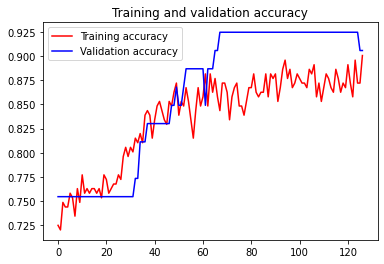

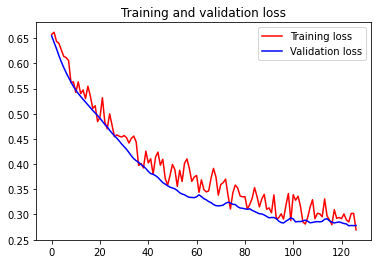

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [29]:
saved_model = load_model('best_model.h5')

loss, acc = saved_model.evaluate(x_test_scaled, y_test)
print("Accuracy: ", acc)
print("Loss: ", loss)

2/2 [==============================] - 0s 6ms/step - loss: 0.2776 - accuracy: 0.9245
Accuracy:  0.9245283007621765
Loss:  0.2776189148426056


In [30]:
normal = [[83,  12.0,  4.0,  29.0,  0,  1],
          [85,  12.0,  4.0,  30.0,  0,  1],
          [70,  14.0,  2.0,  30.0,  1,  0],
          [68,  12.0,  2.0,  27.0,  0,  1]]

dementia = [[77,  20.0,  1.0,  23.0,  0,  1],
            [79,  20.0,  1.0,  25.0,  0,  1],
            [80,  12.0,  3.0,  17.0,  0,  1],
            [73,  16.0,  3.0,  21.0,  1,  0]] 

In [31]:
for row in normal:
  classes = model.predict(scaler.transform([row]))

  print(row)
  print(classes)
  if classes[0] < 0.5:
    print("Normal")
  else:
    print("Dementia")
  
  print()

[83, 12.0, 4.0, 29.0, 0, 1]
[[0.36164877]]
Normal

[85, 12.0, 4.0, 30.0, 0, 1]
[[0.3058967]]
Normal

[70, 14.0, 2.0, 30.0, 1, 0]
[[0.46836326]]
Normal

[68, 12.0, 2.0, 27.0, 0, 1]
[[0.36646762]]
Normal



In [32]:
for row in dementia:
  classes = model.predict(scaler.transform([row]))

  print(row)
  print(classes)
  if classes[0] < 0.5:
    print("Normal")
  else:
    print("Dementia")
  
  print()

[77, 20.0, 1.0, 23.0, 0, 1]
[[0.8839016]]
Dementia

[79, 20.0, 1.0, 25.0, 0, 1]
[[0.8627554]]
Dementia

[80, 12.0, 3.0, 17.0, 0, 1]
[[0.86778307]]
Dementia

[73, 16.0, 3.0, 21.0, 1, 0]
[[0.8852278]]
Dementia

